<a href="https://colab.research.google.com/github/rmkenv/newsletter/blob/main/newsletter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-61687216.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range('2024-05-01', periods=24*31, freq='H')


Test MAE: 2.76 kWh


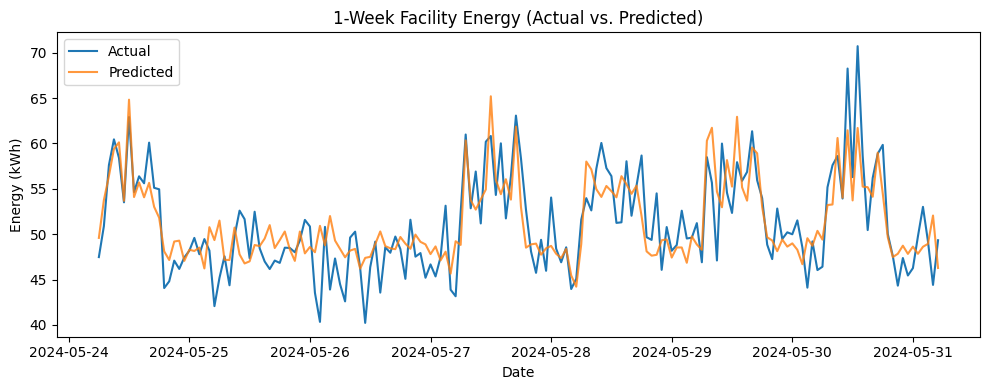

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Simulated facility: one month, hourly resolution
np.random.seed(42)
hours = pd.date_range('2024-05-01', periods=24*31, freq='H')
temp = 22 + 7 * np.sin((hours.dayofyear-120)*2*np.pi/365) + np.random.normal(0,2,len(hours))
occupancy = ((hours.hour >= 7) & (hours.hour < 19) & (hours.dayofweek < 5)).astype(int)  # Workday hours
day_type = (hours.dayofweek >= 5).astype(int)  # 1 for weekend

# Energy profile: HVAC dominates, with base load and plug/lighting
base = 40
hvac = (np.maximum(23-temp, 0)*1.6 + np.maximum(temp-24, 0)*2.0) * occupancy
light_plug = 8 + 5*occupancy
energy_kwh = base + hvac + light_plug + np.random.normal(0,3,len(hours))

df = pd.DataFrame({
    'datetime': hours,
    'temp': temp,
    'occupancy': occupancy,
    'day_type': day_type,
    'energy_kwh': energy_kwh
})

# ML energy prediction
feature_cols = ['temp', 'occupancy', 'day_type', 'datetime']
df['hour'] = df['datetime'].dt.hour
features = ['temp', 'occupancy', 'day_type', 'hour']

split = int(len(df)*0.75)
X_train, X_test = df[features][:split], df[features][split:]
y_train, y_test = df['energy_kwh'][:split], df['energy_kwh'][split:]

rf = RandomForestRegressor(n_estimators=80, random_state=4)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
print(f"Test MAE: {mae:.2f} kWh")

# Plotting one week actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(df['datetime'][split:split+168], y_test[:168], label='Actual')
plt.plot(df['datetime'][split:split+168], pred[:168], label='Predicted', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.title('1-Week Facility Energy (Actual vs. Predicted)')
plt.legend()
plt.tight_layout()
plt.show()
